# E07 Sentiment Classification

In [6]:
!pip list | grep gensim
!pip install konlpy 
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

gensim                        3.6.0
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 448 kB 45.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/comput

## 1. 데이터 준비와 확인

In [7]:
import re
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline

from konlpy.tag import Mecab
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

PATH = '/content/drive/MyDrive/Github/AIFFEL/E07'

In [8]:
train_data = pd.read_table(PATH+'/data/ratings_train.txt')
test_data = pd.read_table(PATH+'/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. Data loader 구성하기

In [9]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [11]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)# 데이터의 중복 제거
    train_data = train_data.dropna(how = 'any') #NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}# 딕셔너리에 {word:index} 구조로 저장

    #텍스트 스트링을 사전 인덱스 스트링으로 변환하는 함수    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  

In [12]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test))) 

train data 개수: 146182, test data 개수: 49157


In [15]:
#사전 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
len(index_to_word)

10000

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공


In [10]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296


In [11]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [13]:
print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


## 4. validation set 구성

In [14]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [15]:
print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 48)
(30000,)
(116182, 48)
(116182,)


## 5. 모델구성


### 5.1. LSTM

In [16]:
 vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))

In [17]:
LSTM_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


모델 훈련 개시

In [18]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [20]:
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3631/3631 [==============================] - 70s 17ms/step - loss: 0.3724 - accuracy: 0.8340 - val_loss: 0.3213 - val_accuracy: 0.8609

Epoch 00001: saving model to best_model.h5
Epoch 2/20
3631/3631 [==============================] - 62s 17ms/step - loss: 0.2863 - accuracy: 0.8796 - val_loss: 0.3095 - val_accuracy: 0.8652

Epoch 00002: saving model to best_model.h5
Epoch 3/20
3631/3631 [==============================] - 61s 17ms/step - loss: 0.2414 - accuracy: 0.9000 - val_loss: 0.3197 - val_accuracy: 0.8663

Epoch 00003: saving model to best_model.h5
Epoch 4/20
3631/3631 [==============================] - 61s 17ms/step - loss: 0.1997 - accuracy: 0.9195 - val_loss: 0.3507 - val_accuracy: 0.8647

Epoch 00004: saving model to best_model.h5
Epoch 5/20
3631/3631 [==============================] - 62s 17ms/step - loss: 0.1619 - accuracy: 0.9365 - val_loss: 0.3929 - val_accuracy: 0.8617

Epoch 00005: saving model to best_model.h5
Epoch 6/20
3631/3631 [============================

In [21]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.5051 - accuracy: 0.8489
[0.5050665140151978, 0.8488516211509705]


Loss, Accuracy 그래프 시각화

In [22]:
LSTM_history_dict = LSTM_history.history

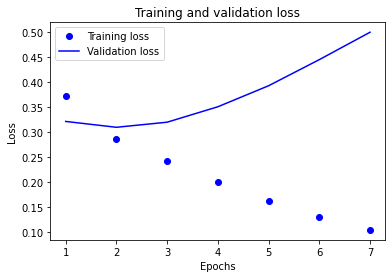

In [23]:
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

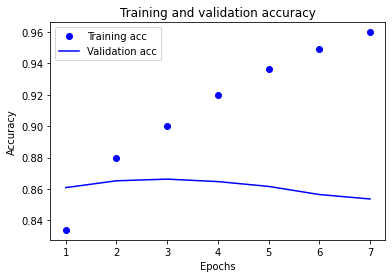

In [24]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Embedding layer 분석


In [25]:
embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [26]:
word2vec_file_path = PATH + '/data/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.21837796, -0.11489076,  0.0505362 ,  0.25060606,  0.06628595,
       -0.15666063, -0.24991193, -0.14994356, -0.22309954, -0.05733933,
        0.02656402,  0.13446692,  0.01183771,  0.16906951, -0.27010003,
       -0.15313569, -0.01549629, -0.17544368, -0.21520828,  0.42896345,
        0.06389125,  0.21205524,  0.29863915, -0.03142805,  0.14724694,
        0.06658994, -0.13512836, -0.24661711, -0.0981413 , -0.0565081 ,
       -0.22850907, -0.14185113, -0.12289011,  0.09552285, -0.05525552,
        0.290723  , -0.1350023 , -0.1663169 , -0.12835675, -0.37495312,
        0.01268779, -0.05592328, -0.03351009,  0.00120508,  0.05892263,
        0.22313404, -0.0333164 ,  0.27924833, -0.21718548, -0.36043927,
       -0.03399455,  0.14317688, -0.3163997 ,  0.08579357,  0.12985443,
        0.06602875, -0.05468769,  0.071546  , -0.18031926,  0.19095325,
        0.1518203 , -0.200239  ,  0.05889826, -0.0684978 , -0.18911105,
       -0.1671925 , -0.11113297, -0.2514634 ,  0.2567392 , -0.26

In [28]:
word_vectors.similar_by_word("감동")

[('신선', 0.8856452107429504),
 ('강추', 0.8818253874778748),
 ('즐겁', 0.8787169456481934),
 ('괜춘', 0.8643598556518555),
 ('감탄', 0.8628779649734497),
 ('레전드', 0.8572136163711548),
 ('편한', 0.8572062253952026),
 ('입감', 0.8561877012252808),
 ('구하', 0.8558658957481384),
 ('누군가', 0.8531193733215332)]

한국어 Word2Vec 임베딩 활용하여 성능개선


In [29]:
word2vec_path = PATH + '/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [30]:
word2vec.similar_by_word("감동")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [31]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [32]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(64))
LSTM_ko.add(keras.layers.Dense(256, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [33]:
LSTM_ko.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


In [34]:
LSTM_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best_model_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [36]:
history = LSTM_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3631/3631 [==============================] - 64s 17ms/step - loss: 0.3882 - accuracy: 0.8238 - val_loss: 0.3358 - val_accuracy: 0.8535

Epoch 00001: saving model to best_model_ko.h5
Epoch 2/20
3631/3631 [==============================] - 61s 17ms/step - loss: 0.2935 - accuracy: 0.8764 - val_loss: 0.3148 - val_accuracy: 0.8659

Epoch 00002: saving model to best_model_ko.h5
Epoch 3/20
3631/3631 [==============================] - 62s 17ms/step - loss: 0.2508 - accuracy: 0.8952 - val_loss: 0.3149 - val_accuracy: 0.8672

Epoch 00003: saving model to best_model_ko.h5
Epoch 4/20
3631/3631 [==============================] - 61s 17ms/step - loss: 0.2127 - accuracy: 0.9125 - val_loss: 0.3306 - val_accuracy: 0.8679

Epoch 00004: saving model to best_model_ko.h5
Epoch 5/20
3631/3631 [==============================] - 61s 17ms/step - loss: 0.1767 - accuracy: 0.9296 - val_loss: 0.3598 - val_accuracy: 0.8613

Epoch 00005: saving model to best_model_ko.h5
Epoch 6/20
3631/3631 [=============

In [37]:
loaded_model = load_model('best_model_ko.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.4659 - accuracy: 0.8548
[0.46590572595596313, 0.8548324704170227]


### 5.2. 1-D CNN

In [38]:
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 32)            19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 16)             1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [39]:
model_cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_cnn=5
history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_cnn,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/5
908/908 [==============================] - 35s 10ms/step - loss: 0.4910 - accuracy: 0.7555 - val_loss: 0.3924 - val_accuracy: 0.8229
Epoch 2/5
908/908 [==============================] - 9s 9ms/step - loss: 0.3548 - accuracy: 0.8445 - val_loss: 0.3648 - val_accuracy: 0.8380
Epoch 3/5
908/908 [==============================] - 9s 9ms/step - loss: 0.3070 - accuracy: 0.8689 - val_loss: 0.3586 - val_accuracy: 0.8411
Epoch 4/5
908/908 [==============================] - 9s 9ms/step - loss: 0.2753 - accuracy: 0.8857 - val_loss: 0.3612 - val_accuracy: 0.8421
Epoch 5/5
908/908 [==============================] - 9s 9ms/step - loss: 0.2470 - accuracy: 0.8985 - val_loss: 0.3789 - val_accuracy: 0.8406


In [41]:
results2 = model_cnn.evaluate(X_test, y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.3884 - accuracy: 0.8370
[0.3883591890335083, 0.8370323777198792]


### 5.3. GlobalMaxPooling

In [42]:
model_gmp = keras.Sequential()

model_gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_gmp.add(keras.layers.GlobalMaxPooling1D())
model_gmp.add(keras.layers.Dense(8, activation='relu'))
model_gmp.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_gmp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_gmp=10
history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_gmp,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 14s 8ms/step - loss: 0.5646 - accuracy: 0.6996 - val_loss: 0.4756 - val_accuracy: 0.7731
Epoch 2/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.4398 - accuracy: 0.7949 - val_loss: 0.4198 - val_accuracy: 0.8080
Epoch 3/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.3862 - accuracy: 0.8267 - val_loss: 0.3989 - val_accuracy: 0.8191
Epoch 4/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.3510 - accuracy: 0.8467 - val_loss: 0.3856 - val_accuracy: 0.8265
Epoch 5/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.3240 - accuracy: 0.8605 - val_loss: 0.3834 - val_accuracy: 0.8286
Epoch 6/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.3009 - accuracy: 0.8724 - val_loss: 0.3980 - val_accuracy: 0.8257
Epoch 7/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.2787 - accuracy: 0.8841 - val_loss: 0.3865 - val_ac

In [44]:
results3 = model_gmp.evaluate(X_test, y_test, verbose=2)

print(results3)

1537/1537 - 3s - loss: 0.4263 - accuracy: 0.8304
[0.42630237340927124, 0.8303598761558533]
